## Dixon Coles

In [1]:
from dixon_coles import Dixon_Coles
import pandas as pd
import numpy as np

df = pd.read_csv("../data/fivethirtyeight/spi_matches.csv")
df = (df
    .loc[(df['league_id'] == 2411) | (df['league_id'] == 2412)]
    .dropna()
    )

dc_model = Dixon_Coles(df[df['season'] != 2021])
dc_model.optimize()

In [2]:
logos = {
    # https://www.transfermarkt.com/premier-league/transfers/wettbewerb/GB1
    'Arsenal': '../data/logos/ARS.png',
    'Aston Villa': '../data/logos/AVL.png',
    'Brighton and Hove Albion': '../data/logos/BHA.png',
    'Brentford': '../data/logos/BRE.png',
    'Burnley': '../data/logos/BUR.png',
    'Chelsea': '../data/logos/CHE.png',
    'Crystal Palace': '../data/logos/CRY.png',
    'Everton': '../data/logos/EVE.png',
    'Leicester City': '../data/logos/LEI.png',
    'Leeds United': '../data/logos/LEE.png',
    'Liverpool': '../data/logos/LIV.png',
    'Manchester City': '../data/logos/MCI.png',
    'Manchester United': '../data/logos/MUN.png',
    'Norwich City': '../data/logos/NOR.png',
    'Newcastle': '../data/logos/NEW.png',
    'Southampton': '../data/logos/SOU.png',
    'Tottenham Hotspur': '../data/logos/TOT.png',
    'Watford': '../data/logos/WAT.png',
    'West Ham United': '../data/logos/WHU.png',
    'Wolverhampton': '../data/logos/WOL.png',
}

In [9]:
params = dc_model.print_parameters()
params = params[params.team.isin([k for k in logos.keys()])]

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

Text(0, 0.5, 'Defense')

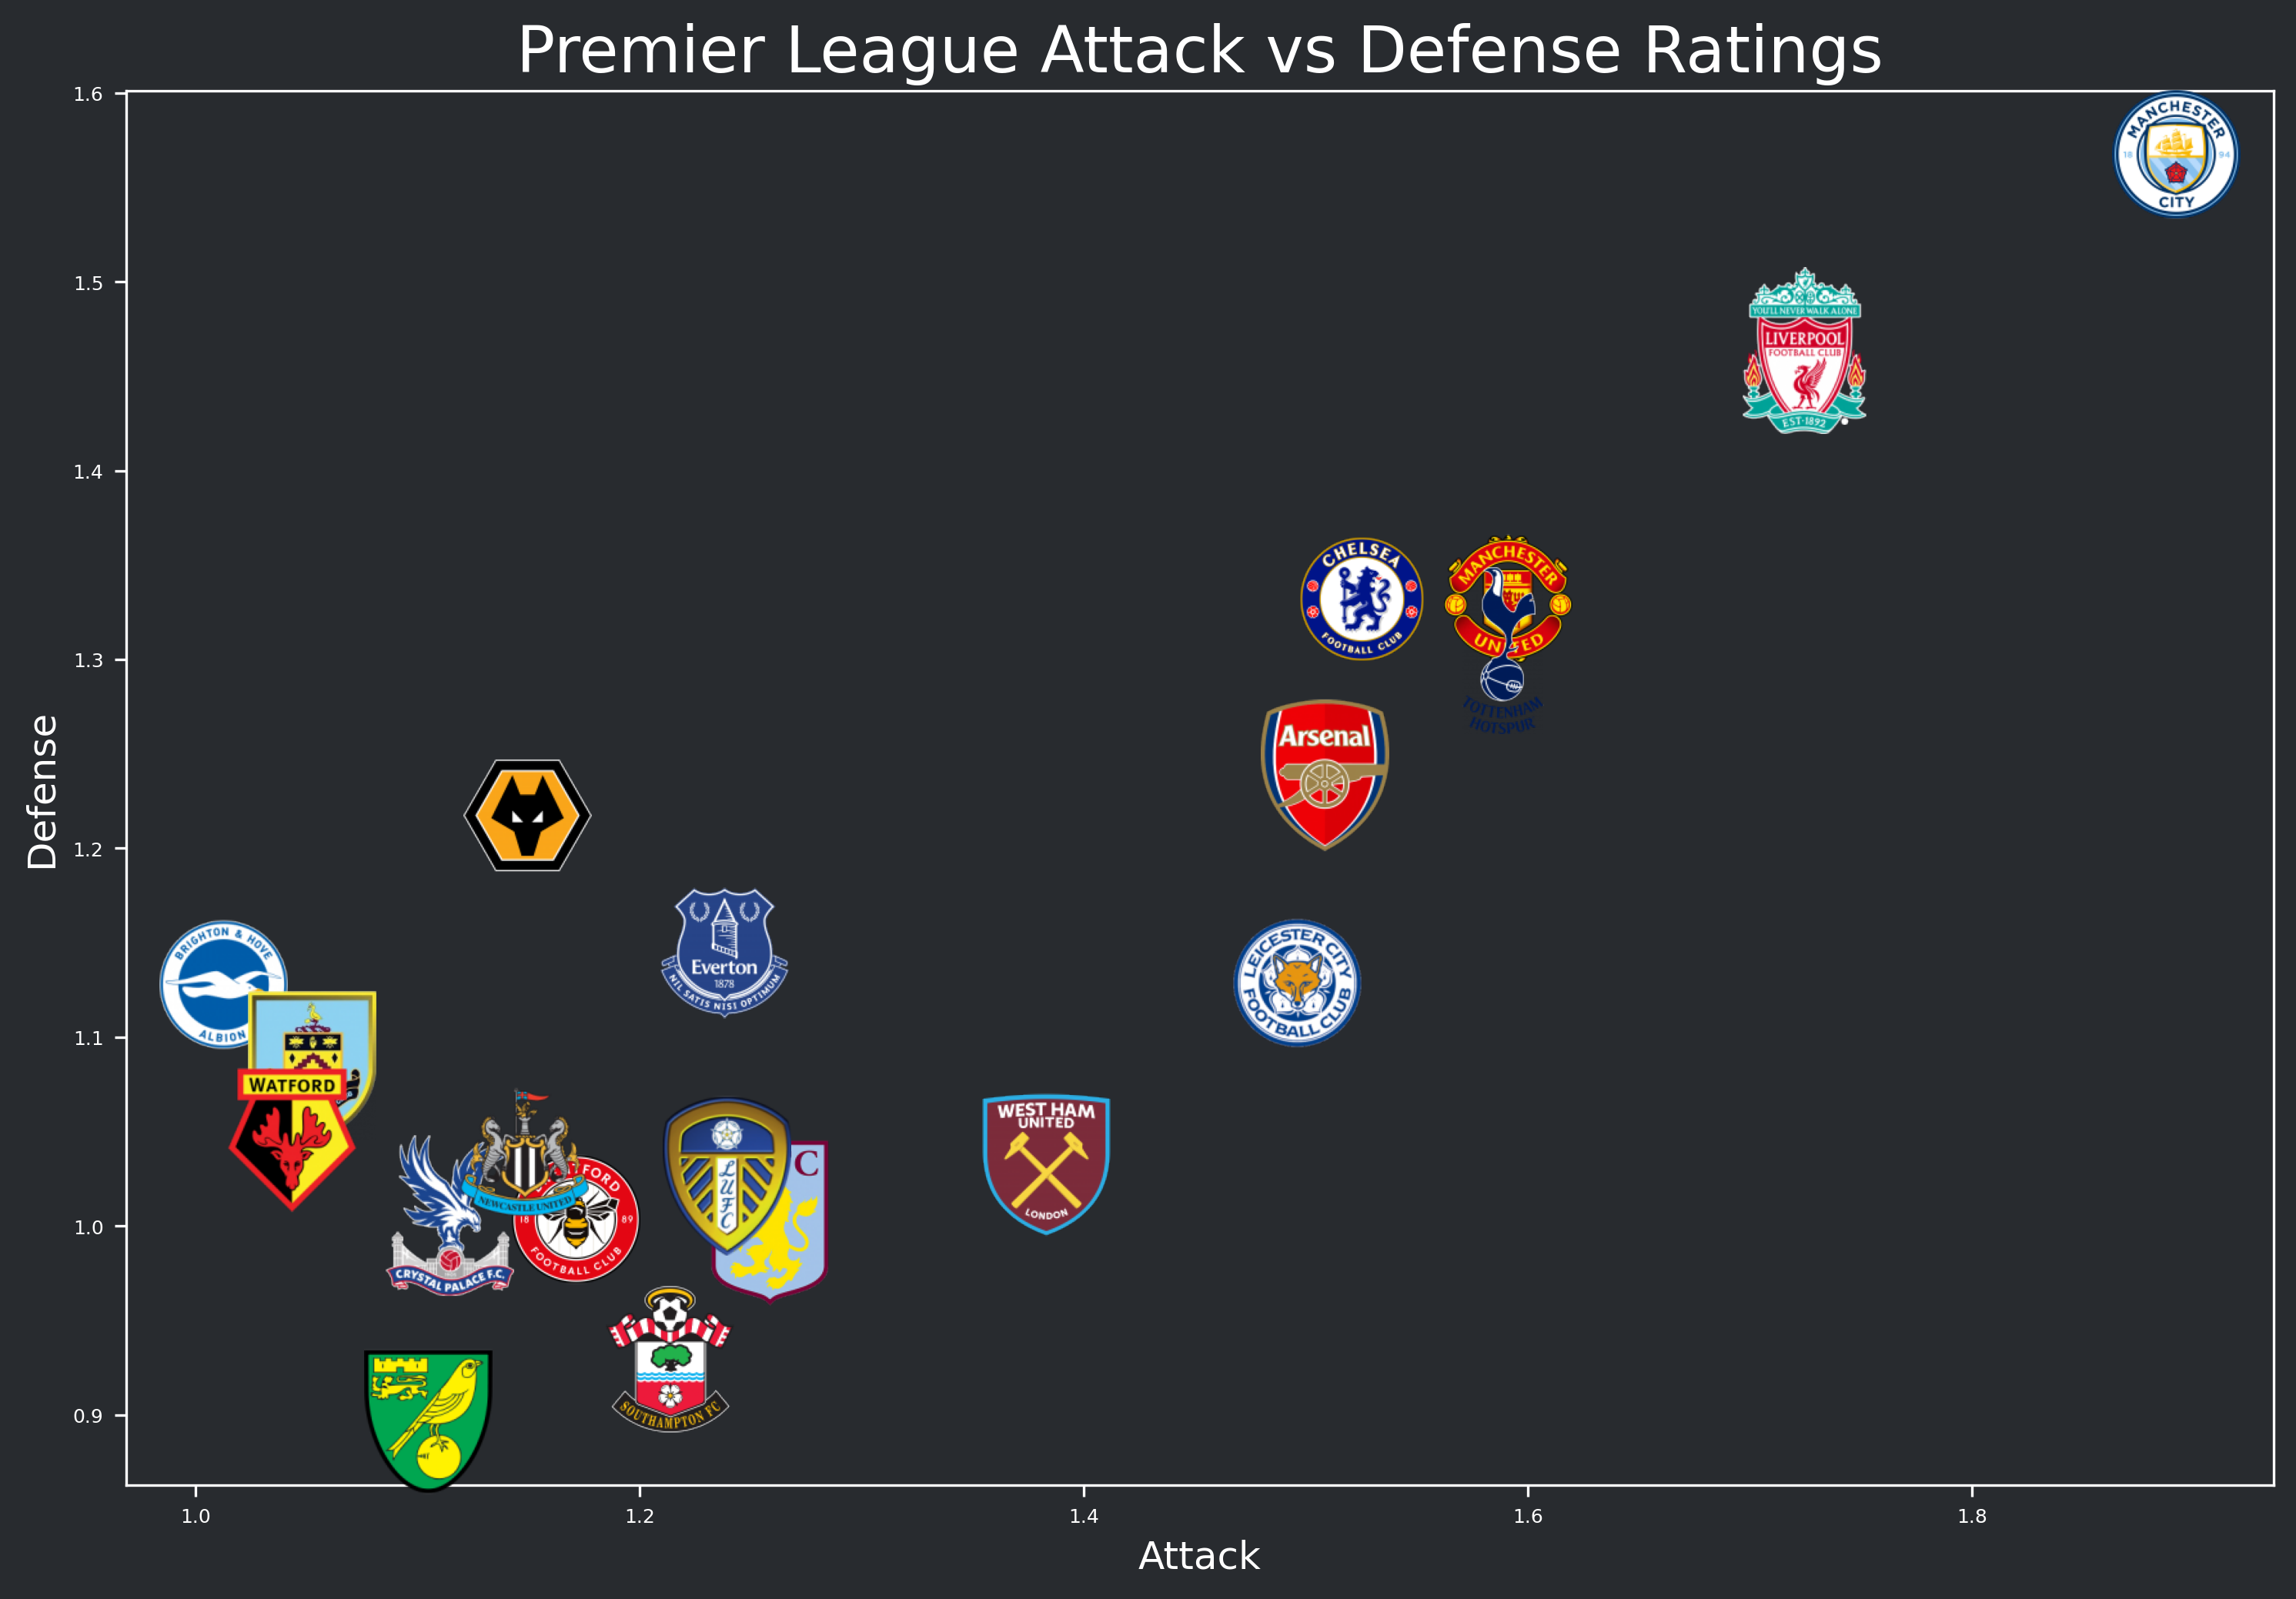

In [16]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path):
    return OffsetImage(plt.imread(path), zoom = 0.4)

fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(params.attack, params.defence, 'o')

for label, x, y in zip(params.team, params.attack, params.defence):
    if label in logos.keys():
        ab = AnnotationBbox(getImage(logos[label]), (x, y), frameon=False)
        ax.add_artist(ab)

ax.title.set(text='Premier League Attack vs Defense Ratings', fontsize=20)
ax.set_xlabel('Attack', fontsize=12, color=text_color)
ax.set_ylabel('Defense' , fontsize=12, color=text_color)

## Bayesian XG

In [17]:
from bayesian_xg import Bayesian_XG

df = pd.read_csv("../data/fivethirtyeight/spi_matches.csv")
df = (df
    .loc[(df['league_id'] == 2411) | (df['league_id'] == 2412)]
    .dropna()
    )

model = Bayesian_XG(df[df['season'] != 2021])
model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [def_star, tau_def, atts_star, tau_att, intercept, home]


Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 29 seconds.


In [18]:
parameter_df = (
    pd.DataFrame()
    .assign(attack=[np.mean([x[team] for x in model.trace["atts"]]) for team in range(model.league_size)])
    .assign(defence=[np.mean([x[team] for x in model.trace["defs"]]) for team in range(model.league_size)])
    .assign(team=np.array(model.teams.team_index.values))
)

aggregate_df = (
    model.games.loc[:, ["team1", "hg"]]
    .drop_duplicates()
    .merge(parameter_df, left_on='hg', right_on='team')
    .assign(home_adv=np.mean(model.trace["home"]))
    .assign(intercept=np.mean([x for x in model.trace["intercept"]]))
    .drop(["hg", "team"], axis=1)
)
aggregate_df.sort_values('attack', ascending=False).head()

,team1,attack,defence,home_adv,intercept
3,Manchester City,0.612886,-0.333108,0.165075,0.147311
19,Liverpool,0.509196,-0.183198,0.165075,0.147311
9,Chelsea,0.363682,-0.277770,0.165075,0.147311
13,Tottenham Hotspur,0.303773,-0.063736,0.165075,0.147311
10,Manchester United,0.296282,-0.148343,0.165075,0.147311


In [19]:
aggregate_df = aggregate_df[aggregate_df.team1.isin([k for k in logos.keys()])]

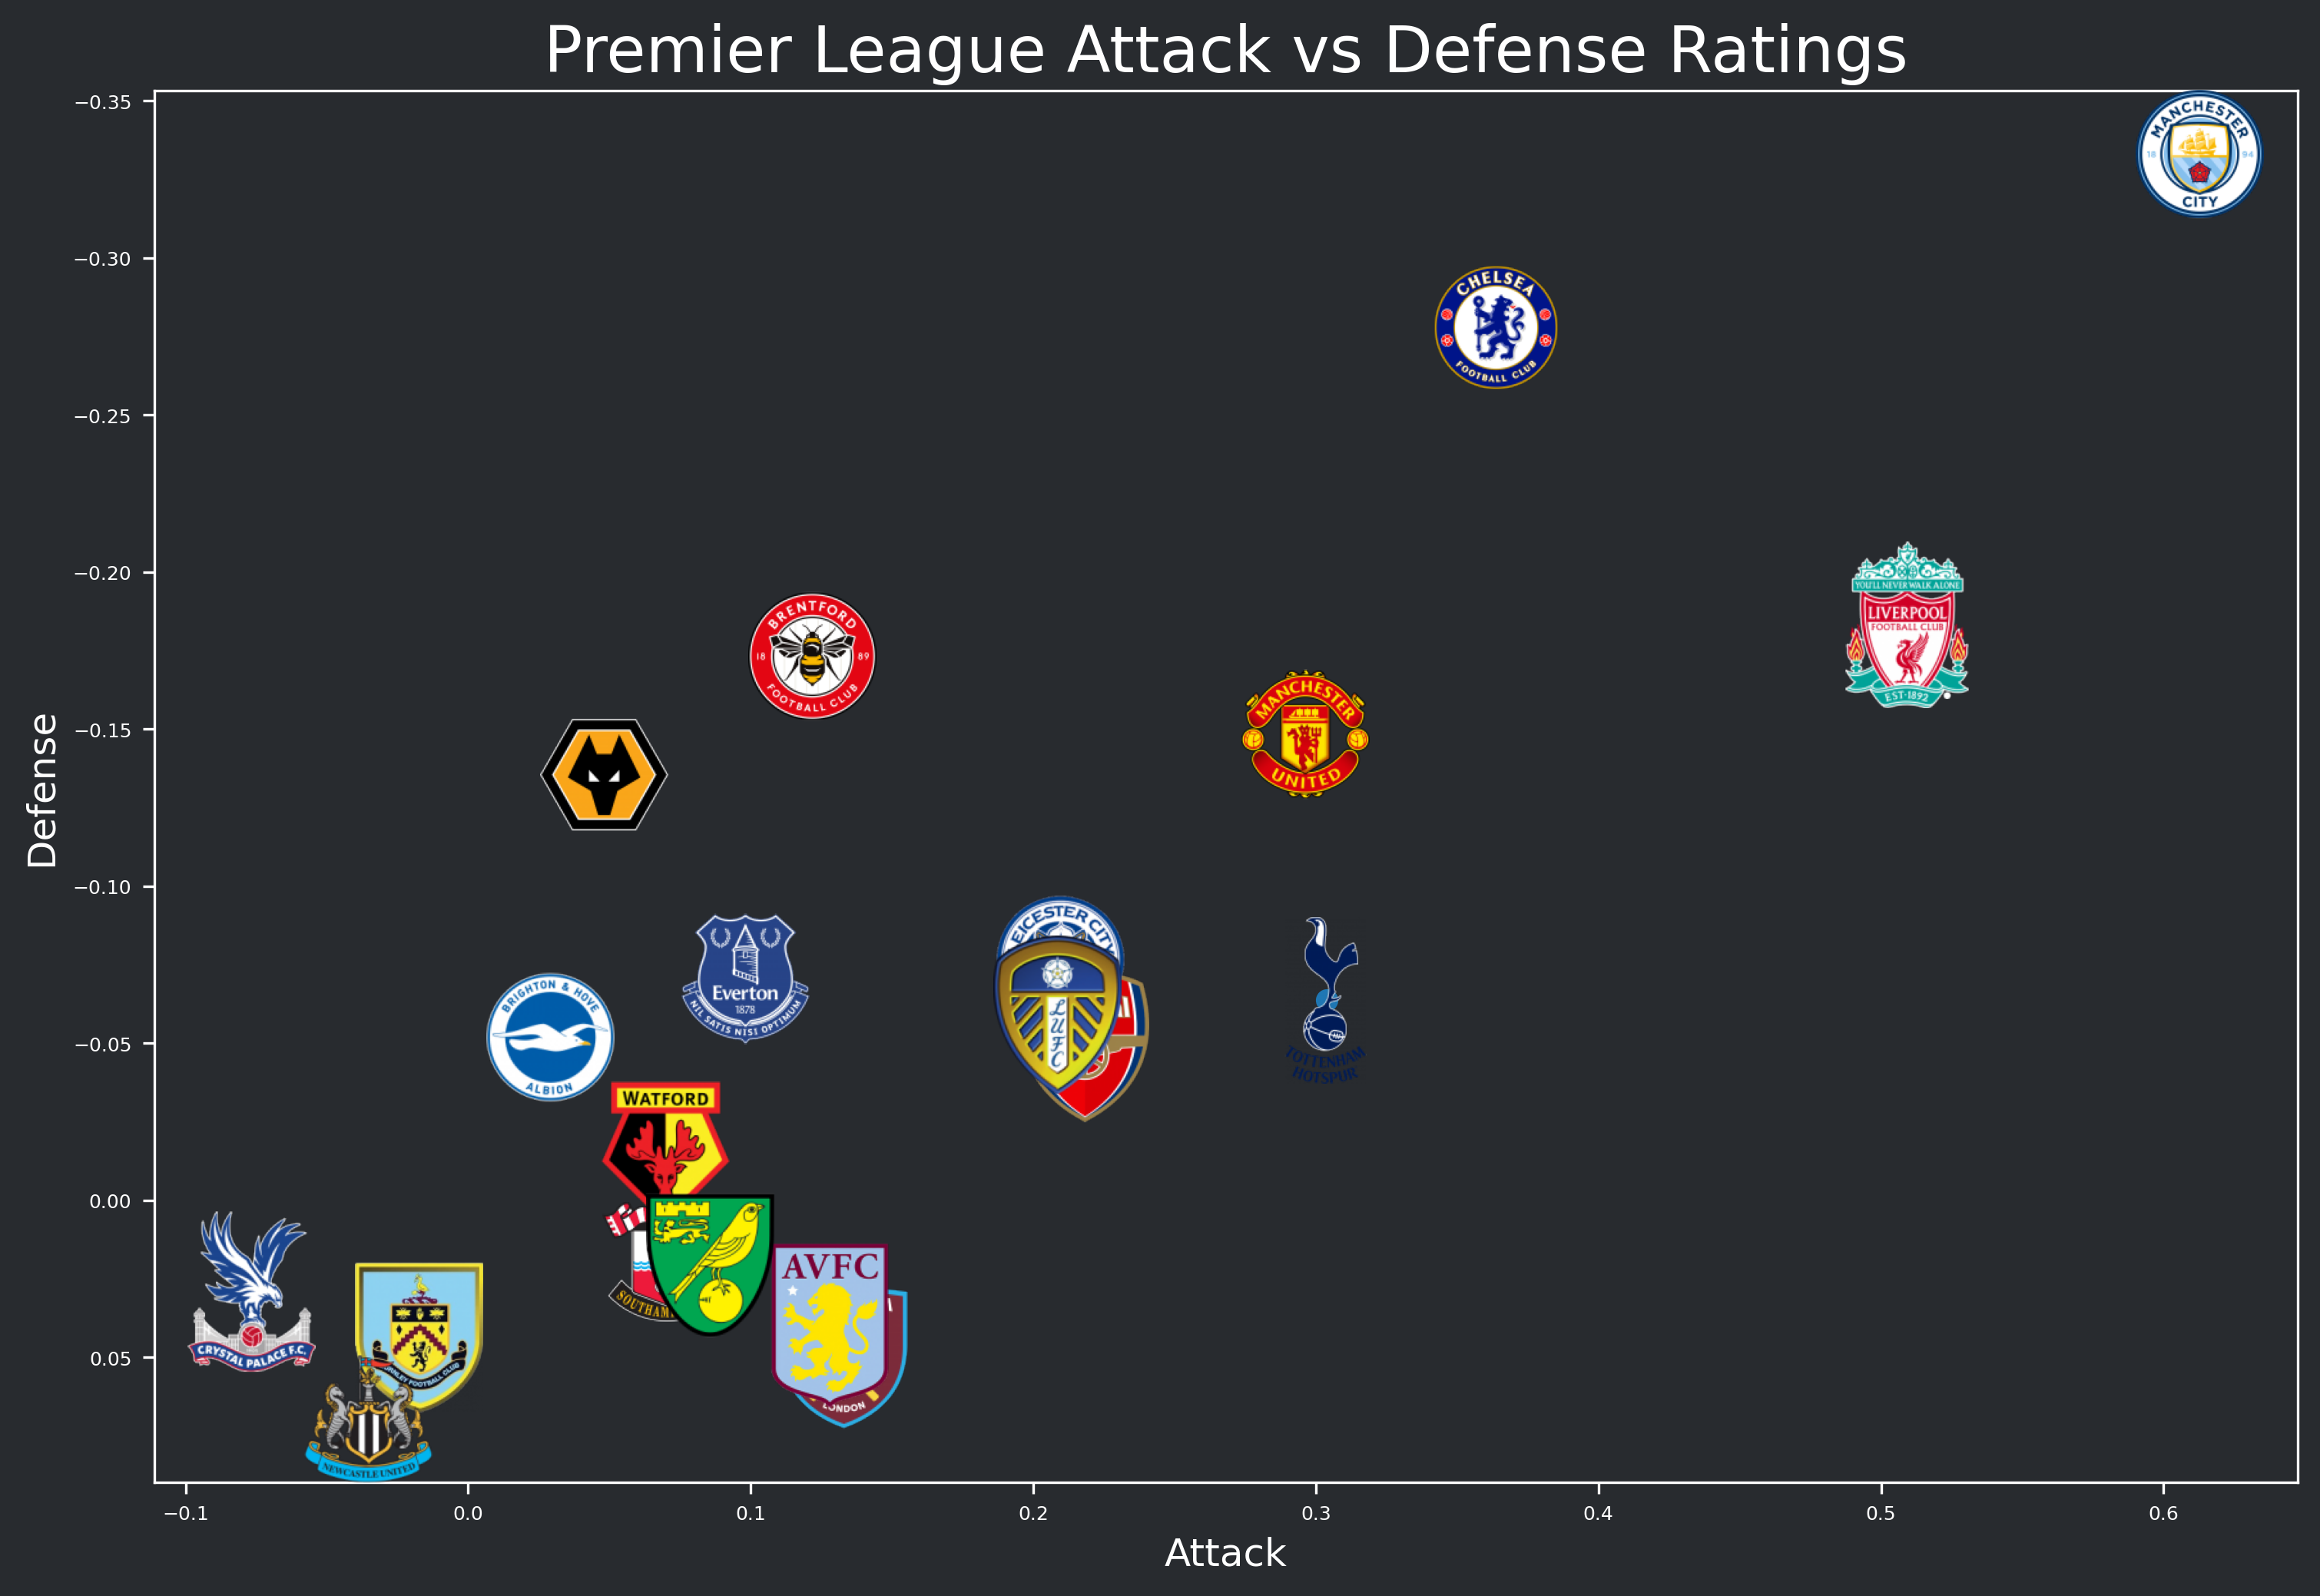

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(aggregate_df.attack, aggregate_df.defence, 'o')

for label, x, y in zip(aggregate_df.team1, aggregate_df.attack, aggregate_df.defence):
    if label in logos.keys():
        ab = AnnotationBbox(getImage(logos[label]), (x, y), frameon=False)
        ax.add_artist(ab)

ax.title.set(text='Premier League Attack vs Defense Ratings', fontsize=20)
ax.set_xlabel('Attack', fontsize=12, color=text_color)
ax.set_ylabel('Defense' , fontsize=12, color=text_color)
ax.invert_yaxis()